# Custom model creation with OCI and python SDK

I'm going to use python SDK to create a custom dataset of images, to train a vision model. 

I'll be using a small part of  the the google landmark dataset v2. (https://github.com/cvdfoundation/google-landmark). The full dataset its of 500 GB but we are going to do some scraping to get only a fraction of those files (around 2GB).

Overview
- Install dependencies
- Download and prepare dataset.
- Explore the dataset
- Upload dataset to bucket.
- Create dataset in OCI
- Create vision project
- Create quick training model.
- Test model
- Delete OCI resources

** It's gona be necesary 4 GB or space on disk.

## Install depenedencies
Install the dependencies needed to execute the project. I'll be using conda

```
conda create --name oci-custom-dataset --file environment.yaml
```


## Download and prepare dataset

In [1]:
# Imports
import os
import re
import time
import requests
import json
import oci
import mimetypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline


In [2]:

# Download csv files of dataset

if not os.path.exists('data'):
    os.mkdir('data')

if not os.path.exists('data/train_clean.csv'):
    open('data/train_clean.csv', 'wb').write(requests.get('https://s3.amazonaws.com/google-landmark/metadata/train_clean.csv').content)

if not os.path.exists('data/train_label_to_category.csv'):
    open('data/train_label_to_category.csv', 'wb').write(requests.get('https://s3.amazonaws.com/google-landmark/metadata/train_label_to_category.csv').content)

if not os.path.exists('data/train_attribution.csv'):
    open('data/train_attribution.csv', 'wb').write(requests.get('https://s3.amazonaws.com/google-landmark/metadata/train_attribution.csv').content)

train_clean = pd.read_csv('data/train_clean.csv')
train_label_to_category = pd.read_csv('data/train_label_to_category.csv')
train_attribution = pd.read_csv('data/train_attribution.csv')



In [2]:
# Choose the labels and images we are going to workn on

labels = {
    "Eiffel_Tower" : "Eiffel Tower",
    "Stonehenge" : "Stonehenge", 
    "Trevi_fountain" : "Trevi fountain",
    "Great_Pyramid_of_Giza" : "Pyramid of Giza",
    "Louvre_Pyramid" : "Louvre Pyramid"
}

In [24]:
train_clean['num_images'] =  train_clean.images.str.split(' ').apply(lambda x: len(x))
train_label_to_category['name'] = train_label_to_category.category.str.slice(43)

train = train_clean.merge(train_label_to_category, on='landmark_id', how='left')
train = train[train.name.isin(labels)]

Next cell will do some scraping to download the images manually one by one, because the alternative would be to download 500 GB of dataset. 

First time it's going to take **6 minutes** to download everything. 

Maybe you want to modify the labels dictionary to work with less entities, but I would not recomend to work with less than 50 images.

In [3]:
images_dir = 'images'
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [6]:
for index, row in train.iterrows():
    images = row.images.split(' ')
    if not os.path.exists(images_dir + '/' + str(row.landmark_id)):
            os.mkdir(images_dir + '/' + str(row.landmark_id))
    else:
        continue
    for i, img in enumerate(images[:50]):
        
        html_url = train_attribution[train_attribution.id == img].url
        if html_url is not None:
            html_url = html_url.values[0]
            html_data = requests.get(html_url).content.decode('utf')
            img_url = re.findall('fullImageLink(.*)href="(.*)"', html_data)
            if len(img_url) > 0:
                img_url = img_url[0][1]
                img_url = img_url[:img_url.find('"')]
                
                headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:102.0) Gecko/20100101 Firefox/102.0'}
                img_data = requests.get(img_url, headers=headers).content
                img_path = images_dir + '/' + str(row.landmark_id) + '/' + img + img_url[img_url.rfind('.'):]
                if os.path.exists(img_path):
                    continue 
                with open(img_path, 'wb') as handler:
                    handler.write(img_data)
                    time.sleep(.50)


We have to check that we have real images (make sure the content-type is correct) , and delete those bigger than 6 MB (restriction of the dataset labeling service). 

In [4]:
if not os.path.exists(images_dir):
    dict_dataset = []
    for landmark_id in os.listdir(images_dir):
        files = []
        content_types = []
        for image in os.listdir(images_dir + '/' + landmark_id):
            flag_deleted = False
            content_type = None
            image_path = images_dir + '/' + landmark_id + '/' + image
            mt = mimetypes.guess_type(image_path)
            if mt:
                content_type = mt[0]
                if mt[0] not in ['image/jpeg', 'image/png']:
                    os.remove(image_path)
                    flag_deleted = True
                    print(image_path, "Deleted because image is not in content-type list: ", content_type)
            else:
                os.remove(image_path)
                flag_deleted = True
                print(image_path, "Deleted by not supported content-type")
            
            if not flag_deleted and os.stat(image_path).st_size / (1024 * 1024) > 5.9:
                os.remove(image_path)
                flag_deleted = True
                print(image_path, "Deleted because file was bigger than 6 MB")


            if not flag_deleted:
                files.append(image_path)
                content_types.append(content_type)

        if len(files) > 0:
            category = train.loc[train.landmark_id == int(landmark_id)]['name'].values[0]
            dict_dataset.append({'landmark_id' : landmark_id, 'images': ' '.join(files), 'content_types' : ' '.join(content_types),
                'category': category, 'label' : labels[category]  })

    dataset = pd.DataFrame(dict_dataset)
    dataset.set_index('landmark_id', inplace=True)
    dataset.to_csv('dataset.csv')
else:
    dataset = pd.read_csv('dataset.csv', index_col='landmark_id')




## Explore dataset
After filtering and cleaning the dataset lets see what do we have.

Text(0.5, 1.0, 'Number of images by label')

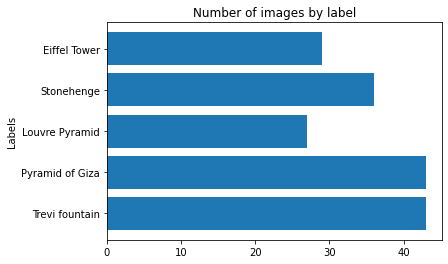

In [7]:
labels_dataset = dataset.label.values
count_images =  dataset.images.str.split(' ').apply(lambda x: len(x))
y_pos = range(len(labels))

plt.barh(labels_dataset, count_images, align='center')
plt.ylabel('Labels')
plt.title('Number of images by label')


So after cleaning the dataset we lost 10 to 20 images by label. 

Lets see some of the images in the dataset.

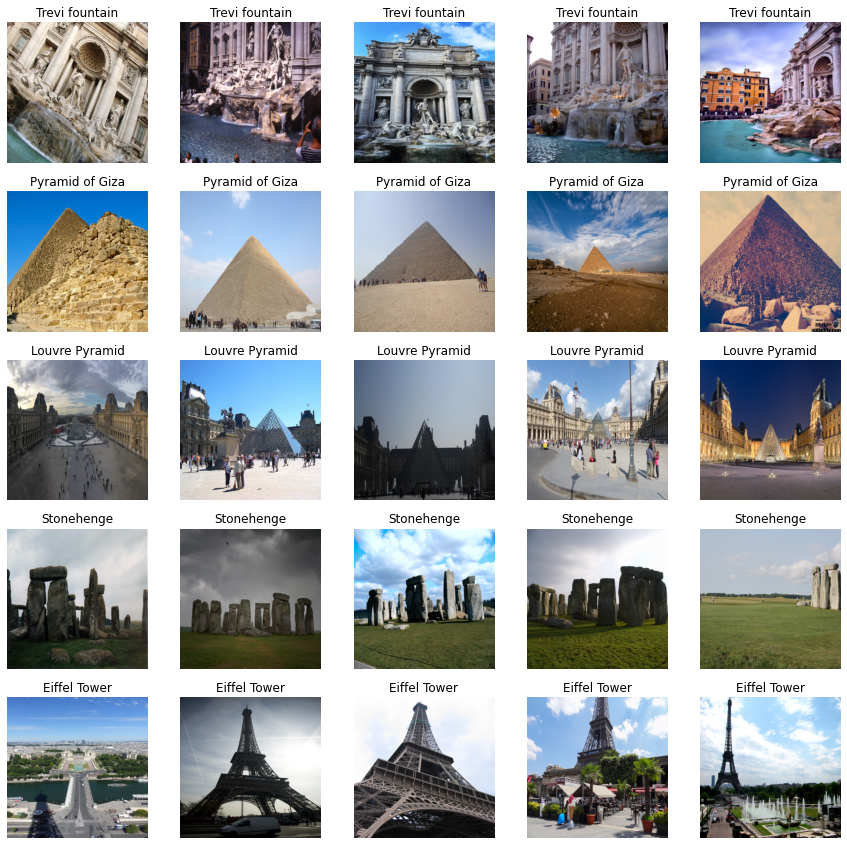

In [12]:

def img_reshape(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((300,300))
    img = np.asarray(img)
    return img

rows = len(labels.keys())
cols = 5

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

for i, (index, row) in enumerate(dataset.iterrows()):
    images = row.images.split(' ')
    for j, img in enumerate(images[:cols]):
        axes[i, j].imshow(img_reshape(img))
        axes[i, j].set_axis_off()
        axes[i, j].set_title(row.label)


The images are noisy a with a lot of other objects around, 50 images are not going to be enough to properly train this model. 
For a real models use more records.

## Upload dataset to bucket
Now we have a our dataset ready to begin the work in OCI. 

We'll need to upload the images to a bucket so we can start work there. 

**There is something really important that I did not mention before, there lots of problems related with the mime-type of the images that the data-labeling service is able to process. That's why I took my time before, to check that all the images had their correct mime-type. Making sure about that, is going to save you a lot of headaches.**


Change the next variables acording with your configuration.

- The OCI config file is created once you authenticate using the OCI cli. Change this value according with youe enviroment.
```
        oci session authenticate
```
- A comparment OCID, where all the resources are going to be created. Change this value with the value you want.

In [5]:
OCI_CONFIG = '~/.oci/config'
COMPARMENT_OCID = 'ocid1.compartment.oc1..aaaaaaaayfetzguxpclcvunjy73spcwx4wnurqa2i6aphhcjaewuvyvu6m5a'
OBJECT_STORAGE_NAMESPACE = 'wedoinfra'
BUCKET_NAME='oci-bucket-dataset'

DATASET_NAME='landmarks-dataset'
VISION_PROJECT_NAME='landmarks-project'
VISION_MODEL_NAME='landmarks-quick-model'


config = oci.config.from_file(OCI_CONFIG)


Create the bucket to upload the dataset

In [24]:
from oci.object_storage import ObjectStorageClient
from oci.object_storage.models import CreateBucketDetails

object_storage_client = ObjectStorageClient(config)

create_bucket_details = CreateBucketDetails(name=BUCKET_NAME, compartment_id=COMPARMENT_OCID, public_access_type=CreateBucketDetails.PUBLIC_ACCESS_TYPE_OBJECT_READ)

response_create_bucket = object_storage_client.create_bucket(namespace_name=OBJECT_STORAGE_NAMESPACE, create_bucket_details=create_bucket_details)

bucket_ocid = response_create_bucket.data.compartment_id


Now upload individually the images. If you had the same mime-type for all the images, is faster to use the bulk upload method.

In [41]:
def upload_file(file, mime_type):
    with open(file, "rb") as image:
        image_content = image.read()

    object_storage_client.put_object(namespace_name=OBJECT_STORAGE_NAMESPACE,
                                     bucket_name=BUCKET_NAME,
                                     object_name=file,
                                     put_object_body=image_content,
                                     content_length=len(image_content),
                                     content_type=mime_type)

for index, row in dataset.iterrows():
    images = row.images.split(' ')
    mine_types = row.content_types.split(' ')

    for image, mime_type in zip(images, mine_types):
        upload_file(image, mime_type)

Next cell is optional but is recomended as fail-safe to make sure that all the images on the bucket has the correct mime-type.

If in the response you find a mime-type not corresponding to an image, check your dataset.

In [43]:
list_files = object_storage_client.list_objects(namespace_name=OBJECT_STORAGE_NAMESPACE, bucket_name=BUCKET_NAME)

mime_types = {}
for item in list_files.data.objects:
    res = object_storage_client.head_object(namespace_name=OBJECT_STORAGE_NAMESPACE, bucket_name=BUCKET_NAME, object_name=item.name)
    mime_types[item.name] = res.headers['Content-Type']

print(set(mime_types.values()))

{'image/jpeg', 'image/png'}


## Create dataset in OCI

Now we are ready to create the dataset.

In [18]:
from oci.data_labeling_service import DataLabelingManagementClient, DataLabelingManagementClientCompositeOperations
from oci.data_labeling_service.models import CreateDatasetDetails, ImageDatasetFormatDetails, \
    ObjectStorageSourceDetails, InitialRecordGenerationConfiguration, Label, LabelSet, AnnotationFormat


data_labeling_management_client = DataLabelingManagementClient(config)
data_labeling_composite_ops = DataLabelingManagementClientCompositeOperations(data_labeling_management_client)


dataset_source_details = ObjectStorageSourceDetails(source_type='OBJECT_STORAGE', namespace=OBJECT_STORAGE_NAMESPACE, bucket=BUCKET_NAME)
dataset_format_details = ImageDatasetFormatDetails()
dataset_format_details.format_type = 'IMAGE'

initial_record_generation_configuration = InitialRecordGenerationConfiguration()
initial_record_generation_configuration.limit = 5000

label_set = LabelSet()
label_set.items = []

for category in dataset.category.values:
    label = Label()
    label.name = category
    label_set.items.append(label)

annotation_format = AnnotationFormat()
annotation_format.name = 'Image'

create_dataset_details = CreateDatasetDetails(display_name=DATASET_NAME, description=DATASET_NAME,
                                              compartment_id=COMPARMENT_OCID,
                                              labeling_instructions='Labeling instructions',
                                              annotation_format='SINGLE_LABEL',
                                              label_set=label_set,
                                              dataset_source_details=dataset_source_details,
                                              dataset_format_details=dataset_format_details,
                                              initial_record_generation_configuration=initial_record_generation_configuration)

#data_label_response = data_labeling_management_client.create_dataset(create_dataset_details=create_dataset_details)
data_label_response = data_labeling_composite_ops.create_dataset_and_wait_for_state(create_dataset_details=create_dataset_details)
dataset_ocid = data_label_response.data.id


"\ndataset_source_details = ObjectStorageSourceDetails(source_type='OBJECT_STORAGE', namespace=OBJECT_STORAGE_NAMESPACE, bucket=BUCKET_NAME)\ndataset_format_details = ImageDatasetFormatDetails()\ndataset_format_details.format_type = 'IMAGE'\n\ninitial_record_generation_configuration = InitialRecordGenerationConfiguration()\ninitial_record_generation_configuration.limit = 5000\n\nlabel_set = LabelSet()\nlabel_set.items = []\n\nfor category in dataset.category.values:\n    label = Label()\n    label.name = category\n    label_set.items.append(label)\n\nannotation_format = AnnotationFormat()\nannotation_format.name = 'Image'\n\ncreate_dataset_details = CreateDatasetDetails(display_name=DATASET_NAME, description=DATASET_NAME,\n                                              compartment_id=COMPARMENT_OCID,\n                                              labeling_instructions='Labeling instructions',\n                                              annotation_format='SINGLE_LABEL',\n             

The dataset was created, and now is time to label each image.


In [54]:
from oci.data_labeling_service_dataplane import DataLabelingClient
from oci.data_labeling_service_dataplane.models import CreateRecordDetails, RecordMetadata, CreateObjectStorageSourceDetails, \
    CreateAnnotationDetails, GenericEntity, Label

data_labeling_client = DataLabelingClient(config)

list_records = data_labeling_client.list_records(compartment_id=COMPARMENT_OCID, dataset_id=dataset_ocid, limit=1000)
list_annotations = data_labeling_client.list_annotations(compartment_id=COMPARMENT_OCID, dataset_id=dataset_ocid, limit=1000)

records = {}
for record_summary in list_records.data.items:
    records[record_summary.name] = record_summary.id

while list_records.has_next_page:
    list_records = data_labeling_client.list_records(compartment_id=COMPARMENT_OCID, dataset_id=dataset_ocid, limit=1000, page=list_records.next_page)
    for record_summary in list_records.data.items:
        records[record_summary.name] = record_summary.id

annotations = {}
for annotation_summary in list_annotations.data.items:
    annotations[annotation_summary.record_id] = 0

while list_annotations.has_next_page:
    list_annotations = data_labeling_client.list_annotations(compartment_id=COMPARMENT_OCID, dataset_id=dataset_ocid, limit=1000, page=list_annotations.next_page)
    for annotation_summary in list_annotations.data.items:
        annotations[annotation_summary.record_id] = 0


for index, row in dataset.iterrows():
    images = row.images.split(' ')
    for img_path in images:
        record_metadata = RecordMetadata()
        record_metadata.record_type = record_metadata.RECORD_TYPE_IMAGE_METADATA

        create_source_details = CreateObjectStorageSourceDetails()
        create_source_details.source_type = create_source_details.SOURCE_TYPE_OBJECT_STORAGE
        create_source_details.relative_path = img_path

        if img_path in records:
            record_id = records[img_path]
        else:
            create_record_details = CreateRecordDetails(compartment_id=COMPARMENT_OCID,
                                                        dataset_id=dataset_ocid,
                                                        name=img_path,
                                                        record_metadata=record_metadata,
                                                        source_details=create_source_details)

            record = data_labeling_client.create_record(create_record_details)
            record_id = record.data.id
        
        if record_id not in annotations:
            label_set = []
            label = Label()
            label.label = row.category
            label_set.append(label)

            generic_entity = GenericEntity(labels=label_set)

            create_annotation_details = CreateAnnotationDetails(compartment_id=COMPARMENT_OCID,
                                                                record_id=record_id,
                                                                entities=[generic_entity])

            data_labeling_client.create_annotation(create_annotation_details)


## Create vision project

The dataset should be ready to create the vision project and the model for training.

In [19]:
from oci.ai_vision import AIServiceVisionClient, AIServiceVisionClientCompositeOperations
from oci.ai_vision.models import DataScienceLabelingDataset, CreateProjectDetails, CreateModelDetails

ai_vision_client = AIServiceVisionClient(config)
ai_vision_composite_ops = AIServiceVisionClientCompositeOperations(ai_vision_client)

create_project_details = CreateProjectDetails(display_name=VISION_PROJECT_NAME, compartment_id=COMPARMENT_OCID)

#project_response = ai_vision_client.create_project(create_project_details)
#project_id = project_response.data.id


In [26]:

training_dataset = DataScienceLabelingDataset(dataset_id=dataset_ocid, dataset_type='DATA_SCIENCE_LABELING')

create_model_details = CreateModelDetails(display_name=VISION_MODEL_NAME, project_id=project_id, compartment_id=COMPARMENT_OCID, 
    training_dataset=training_dataset, max_training_duration_in_hours=0.5, model_type='IMAGE_CLASSIFICATION')


model_response = ai_vision_composite_ops.create_model_and_wait_for_state(create_model_details, wait_for_states=['SUCCEEDED', 'FAILED'])


## Testing the model
Please do not test your model using your training dataset.

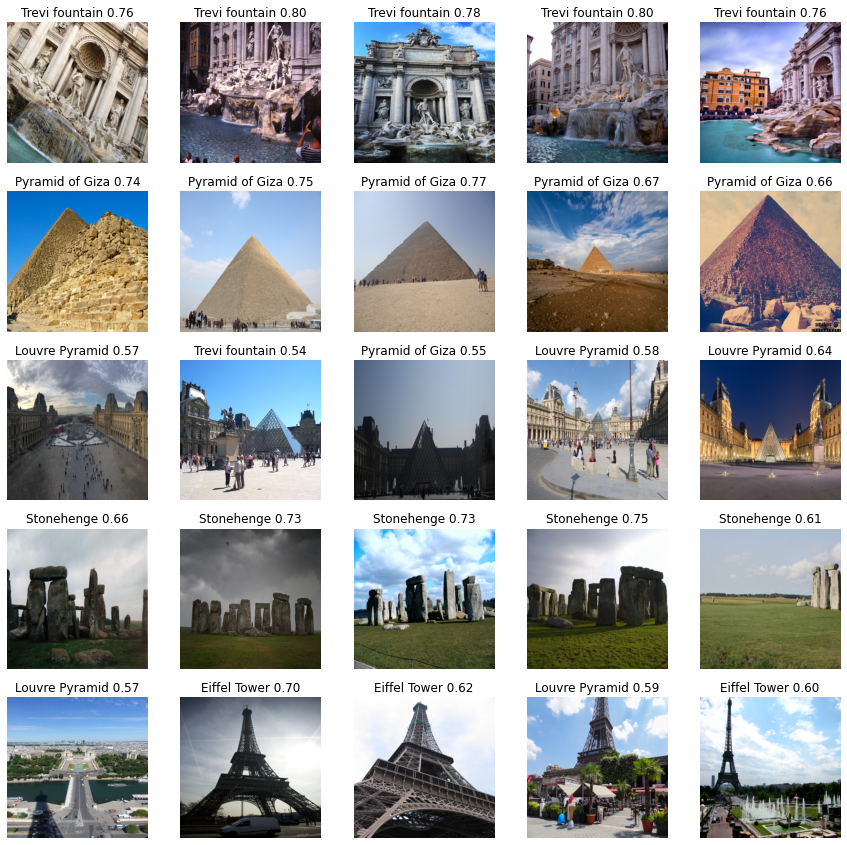

In [15]:
import base64
from oci.ai_vision.models import AnalyzeImageDetails, ImageClassificationFeature, InlineImageDetails

def analize_image(image_path, model_id):

    with open(image_path, "rb") as image_file:
        image_encoded = base64.b64encode(image_file.read())

    image_details = InlineImageDetails()
    image_details.data = image_encoded.decode('utf-8')

    image_text_detection_feature = ImageClassificationFeature(model_id=model_id)
    analyze_image_details = AnalyzeImageDetails(image=image_details, features=[image_text_detection_feature])

    analysis_response = ai_vision_client.analyze_image(analyze_image_details=analyze_image_details)

    return analysis_response.data
    

rows = len(labels.keys())
cols = 5

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

for i, (index, row) in enumerate(dataset.iterrows()):
    images = row.images.split(' ')
    for j, img in enumerate(images[:cols]):
        analysis_response = analize_image(img, 'ocid1.aivisionmodel.oc1.eu-frankfurt-1.amaaaaaaqtij3maaxmcowrowfajqoyu4thu364stusc5lwxgc5huvwsfvira').labels[0]
        axes[i, j].imshow(img_reshape(img))
        axes[i, j].set_axis_off()
        axes[i, j].set_title(labels[analysis_response.name] + ' ' + '%.2f' % analysis_response.confidence)


## Delete OCI resources
Lets clean everything


In [26]:
model_id='ocid1.aivisionmodel.oc1.eu-frankfurt-1.amaaaaaaqtij3maaxmcowrowfajqoyu4thu364stusc5lwxgc5huvwsfvira'
project_id ='ocid1.aivisionproject.oc1.eu-frankfurt-1.amaaaaaaqtij3maadl4uz2byenpvnkhf23vtyw4573puiulr6yhphywdjlga'
dataset_ocid='ocid1.datalabelingdataset.oc1.eu-frankfurt-1.amaaaaaaqtij3maa5o7k3fwjt5cqwsvdqr57eqggvasns4on23ydwjsfsewq'

ai_vision_composite_ops.delete_model_and_wait_for_state(model_id=model_id, wait_for_states=['SUCCEEDED', 'FAILED'])

ai_vision_composite_ops.delete_project_and_wait_for_state(project_id=project_id, wait_for_states=['SUCCEEDED', 'FAILED'])

data_labeling_composite_ops.delete_dataset_and_wait_for_state(dataset_id=dataset_ocid, wait_for_states=['SUCCEEDED', 'FAILED'])


ServiceError: {'target_service': 'object_storage', 'status': 409, 'code': 'BucketNotEmpty', 'opc-request-id': 'fra-1:JujCkkepuyAiqDIw6HUNZjJW13pHOkD69aqT-IKaIZoApABrS6N-8nto_yC8wLeg', 'message': "Bucket named 'oci-bucket-dataset' is not empty. Delete all object versions first.", 'operation_name': 'delete_bucket', 'timestamp': '2022-06-25T10:18:17.408512', 'client_version': 'Oracle-PythonSDK/2.72.0', 'request_endpoint': 'DELETE https://objectstorage.eu-frankfurt-1.oraclecloud.com/n/wedoinfra/b/oci-bucket-dataset', 'logging_tips': 'To get more info on the failing request, refer to https://docs.oracle.com/en-us/iaas/tools/python/latest/logging.html for ways to log the request/response details.', 'troubleshooting_tips': "See https://docs.oracle.com/iaas/Content/API/References/apierrors.htm#apierrors_409__409_bucketnotempty for more information about resolving this error. Also see https://docs.oracle.com/iaas/api/#/en/objectstorage/20160918/Bucket/DeleteBucket for details on this operation's requirements. If you are unable to resolve this object_storage issue, please contact Oracle support and provide them this full error message."}